In [ ]:

# loan_default_pipeline.py
# Requirements: pandas, numpy, scikit-learn, xgboost, imbalanced-learn, shap, matplotlib, seaborn
# pip install pandas numpy scikit-learn xgboost imbalanced-learn shap matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report, brier_score_loss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")
import pathlib



You can upload files directly to your Colab environment using the `files.upload()` function from `google.colab`.

In [ ]:
# 1. Load data (sample data used from kaggle"https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset?select=cs-training.csv")
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')



Saving cs-training.csv to cs-training.csv
User uploaded file "cs-training.csv" with length 7564965 bytes


In [ ]:
df= pd.read_csv(fn)
print("Rows, cols:", df.shape)
display(df.head())

Rows, cols: (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


After uploading, the file will be available in the Colab environment at the path displayed in the output. You can then use this path in your `pd.read_csv()` function.

Class proportions (proportion):
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


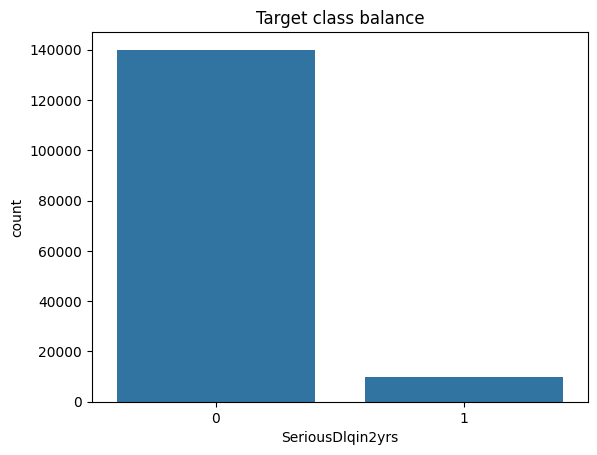

In [ ]:
# 2. Target , basic cleaning & simple EDA
# Many Kaggle credit datasets use column names like 'SeriousDlqin2yrs' as target
TARGET = 'SeriousDlqin2yrs'
print("Class proportions (proportion):")
print(df[TARGET].value_counts(normalize=True))

sns.countplot(x=TARGET, data=df)
plt.title("Target class balance")
plt.show()
df = df.drop(columns=[c for c in df.columns if 'Unnamed' in c])  # drop extra index columns


In [ ]:
# 3. Feature selection: basic numeric/categorical split
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Categorical: []


In [ ]:
# 4. Train/test split (stratified)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# 5. compute imbalance ratio for XGBoost
n_pos = y_train.sum()
n_neg = y_train.shape[0] - n_pos
scale_pos_weight = n_neg / n_pos
print(f"Train: positives={n_pos}, negatives={n_neg}, scale_pos_weight={scale_pos_weight:.2f}")

Train: positives=8021, negatives=111979, scale_pos_weight=13.96


In [ ]:
# 6. Preprocessing pipelines
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

In [ ]:
# 7. Models using class weights no SMOTE here (class-weights approach) ---
# Logistic Regression with class_weight='balanced'
pipeline_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])

# Random Forest with class_weight='balanced'
pipeline_rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42))
])

# XGBoost with scale_pos_weight computed from train set
pipeline_xgb = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          random_state=42, scale_pos_weight=scale_pos_weight,
                          n_estimators=200))
])

In [ ]:
# 8. Fit each model ---
print("Fitting Logistic Regression (class weights)...")
pipeline_lr.fit(X_train, y_train)

print("Fitting Random Forest (class weights)...")
pipeline_rf.fit(X_train, y_train)

print("Fitting XGBoost (scale_pos_weight)...")
pipeline_xgb.fit(X_train, y_train)

Fitting Logistic Regression (class weights)...
Fitting Random Forest (class weights)...
Fitting XGBoost (scale_pos_weight)...


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RevolvingUtilizationOfUnsecuredLines',
                                                   'age',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'DebtRatio', 'MonthlyIncome',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'NumberOfTimes90DaysLate',
                                                   'NumberRealEstateLoa...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

--- LogisticRegression (class_weight) ---
ROC-AUC: 0.8021
              precision    recall  f1-score   support

           0     0.9707    0.7839    0.8673     27995
           1     0.1816    0.6698    0.2858      2005

    accuracy                         0.7762     30000
   macro avg     0.5762    0.7268    0.5766     30000
weighted avg     0.9180    0.7762    0.8285     30000



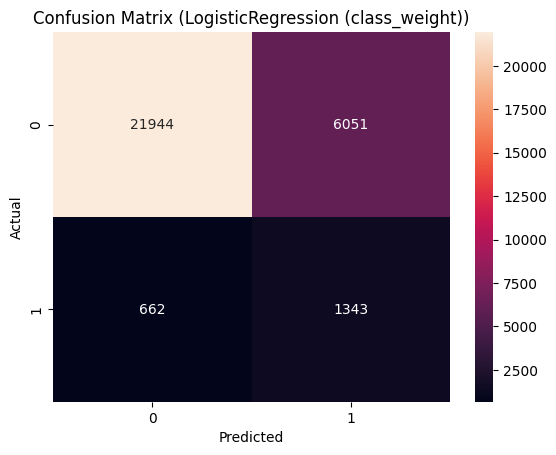

PR-AUC: 0.3265
--- RandomForest (class_weight) ---
ROC-AUC: 0.8402
              precision    recall  f1-score   support

           0     0.9425    0.9912    0.9663     27995
           1     0.5601    0.1556    0.2436      2005

    accuracy                         0.9354     30000
   macro avg     0.7513    0.5734    0.6049     30000
weighted avg     0.9169    0.9354    0.9180     30000



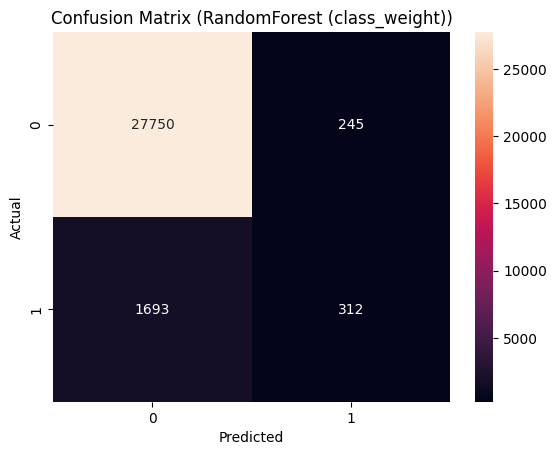

PR-AUC: 0.3538
--- XGBoost (scale_pos_weight) ---
ROC-AUC: 0.8342
              precision    recall  f1-score   support

           0     0.9715    0.8547    0.9093     27995
           1     0.2426    0.6499    0.3533      2005

    accuracy                         0.8410     30000
   macro avg     0.6070    0.7523    0.6313     30000
weighted avg     0.9228    0.8410    0.8722     30000



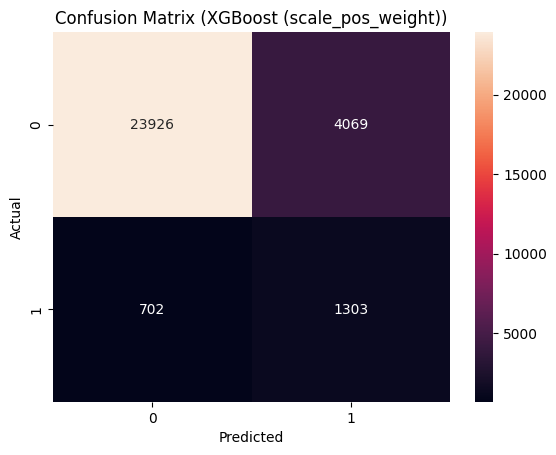

PR-AUC: 0.3419


In [ ]:
# 9. evalate on test set
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report

def evaluate_model(pipeline, X_test, y_test, name="model"):
    probs = pipeline.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)  # default threshold; adjust later
    roc = roc_auc_score(y_test, probs)
    print(f"--- {name} ---")
    print("ROC-AUC: {:.4f}".format(roc))
    print(classification_report(y_test, preds, digits=4))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix ({name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")
    return roc, pr_auc

roc_lr, pr_lr = evaluate_model(pipeline_lr, X_test, y_test, name="LogisticRegression (class_weight)")
roc_rf, pr_rf = evaluate_model(pipeline_rf, X_test, y_test, name="RandomForest (class_weight)")
roc_xgb, pr_xgb = evaluate_model(pipeline_xgb, X_test, y_test, name="XGBoost (scale_pos_weight)")

In [ ]:
# 10.compare results
results = pd.DataFrame({
    'Model': ['LogisticRegression', 'RandomForest', 'XGBoost'],
    'ROC-AUC': [roc_lr, roc_rf, roc_xgb],
    'PR-AUC': [pr_lr, pr_rf, pr_xgb]
})

print("Model Comparison:")
display(results)


Model Comparison:


,Model,ROC-AUC,PR-AUC
0,LogisticRegression,0.802146,0.326550
1,RandomForest,0.840168,0.353832
2,XGBoost,0.834174,0.341919


In [ ]:
# 11. Save best model
best_idx = results['ROC-AUC'].idxmax()
best_model_name = results.loc[best_idx, 'Model']
print("Best model by ROC-AUC:", best_model_name)
# Example: save XGBoost pipeline if it's best
joblib.dump(pipeline_xgb, "best_xgb_with_scale_pos_weight.pkl")
print("Saved best model : best_xgb_with_scale_pos_weight.pkl")

Best model by ROC-AUC: RandomForest
Saved best model : best_xgb_with_scale_pos_weight.pkl
